In [23]:
# Imports
import numpy as np
import pandas as pd
import time
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from google.colab import drive
torch.manual_seed(1000)
drive.mount('/content/gdrive')

from PIL import Image
import os


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:

drive.mount('/content/gdrive')



import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler

# define the parent directory where the train and test subdirectories are located
# CHANGE THIS TO MATCH YOUR PARENT DIRECTORY
parent_dir = '/content/gdrive/MyDrive/aps360/Data_new'

# define the data transformations to be applied to the images
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=256),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])





Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:

# Apply data augmentation techniques on dataset

######## train #############
train_data = datasets.ImageFolder(os.path.join(parent_dir, 'train'), transform=train_transforms)
# set color_mode to 'RGB'
train_data.color_mode = 'RGB'

# set class_mode to 'categorical'
train_data.class_mode = 'categorical'

# Calculate class frequency
class_freq = np.array([len(np.where(np.array(train_data.targets) == t)[0]) for t in range(len(train_data.classes))])
print(f'Class frequency wrt train: {class_freq}')

# Calculate class weights to balance class frequency
class_weights = 1.0 / torch.tensor(class_freq, dtype=torch.float)
print(f'Class weights wrt train: {class_weights}')

# Create sampler to be used in DataLoader
train_targets = torch.tensor(train_data.targets)
train_sampler = WeightedRandomSampler(weights=class_weights[train_targets], num_samples=len(train_targets), replacement=True)

# Confirm balanced class frequency
train_freqs_after_sampler = [0] * len(train_data.classes)
for idx in train_sampler:
    train_freqs_after_sampler[train_data.targets[idx]] += 1
print(f'Class frequency after weighting for training set: {train_freqs_after_sampler}')

train_loader = DataLoader(train_data, batch_size=32,sampler=train_sampler, num_workers=4)

###########################

####### test ###############
test_data = datasets.ImageFolder(os.path.join(parent_dir, 'test'), transform=test_transforms)

# set color_mode to 'RGB'
test_data.color_mode = 'RGB'

# set class_mode to 'categorical'
test_data.class_mode = 'categorical'

# Calculate class frequency
class_freq = np.array([len(np.where(np.array(test_data.targets) == t)[0]) for t in range(len(train_data.classes))])
print(f'Class frequency wrt test: {class_freq}')

# Calculate class weights to balance class frequency
class_weights = 1.0 / torch.tensor(class_freq, dtype=torch.float)
print(f'Class weights wrt test: {class_weights}')

# Create sampler to be used in DataLoader
test_targets = torch.tensor(test_data.targets)
test_sampler = WeightedRandomSampler(weights=class_weights[test_targets], num_samples=len(test_targets), replacement=True)

# Confirm balanced class frequency
freqs = [0] * len(test_data.classes)
for idx in test_sampler:
    freqs[test_data.targets[idx]] += 1
print(f'Class frequency after weighting for test set: {freqs}')
test_loader = DataLoader(test_data, batch_size=32, sampler=test_sampler, num_workers=4)

############################







Class frequency wrt train: [ 470 1266 3419]
Class weights wrt train: tensor([0.0021, 0.0008, 0.0003])
Class frequency after weighting for training set: [1703, 1739, 1713]
Class frequency wrt test: [116 317 855]
Class weights wrt test: tensor([0.0086, 0.0032, 0.0012])
Class frequency after weighting for test set: [440, 425, 423]


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Exploratory statistical analysis



[ 470 1266 3419]


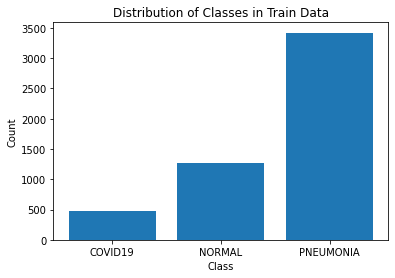

In [28]:
# Exploratory statistical analysis

# Get class names and counts
class_names = train_data.classes
class_counts = np.bincount(train_data.targets)
print(class_counts)

# Create bar chart for training data distrib b4 apply weighted sampler
fig, ax = plt.subplots()
ax.bar(class_names, class_counts)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in Train Data')
plt.show()


from torchvision.transforms import ToPILImage





In [32]:
#  Compute mean and standard deviation of ALL images( no sampler applied)
mean = 0.0
std = 0.0
to_pil = ToPILImage()
for img, _ in train_data:
    img = to_pil(img)  # Convert tensor to PIL Image
    mean += torch.mean(TF.to_tensor(img))
    std += torch.std(TF.to_tensor(img))

mean /= len(train_data)
std /= len(train_data)

print(f'Mean: {mean:.4f}, Std: {std:.4f}')

Mean: 0.5046, Std: 0.2973


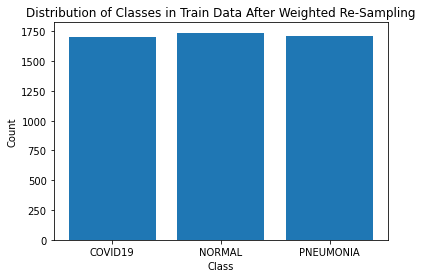

In [31]:
# Exploratory statistical analysis

class_names = train_data.classes


# Create bar chart for training data distrib after apply weighted sampler
fig, ax = plt.subplots()
ax.bar(class_names, train_freqs_after_sampler)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in Train Data After Weighted Re-Sampling')
plt.show()


# Separate code and import for baseline model

In [9]:
!apt-get install git -y
!git clone https://github.com/KevinGe00/Pneumonia-CNN-Classifier.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Cloning into 'Pneumonia-CNN-Classifier'...
remote: Enumerating objects: 6415, done.
remote: Counting objects: 100% (6415/6415), done.
remote: Compressing objects: 100% (6412/6412), done.
^C


In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn import svm, metrics

# Define the paths to the train and test datasets
train_path = '/content/Pneumonia-CNN-Classifier/Data_new/train'
test_path = '/content/Pneumonia-CNN-Classifier/Data_new/test'

# Load the training images and their labels
train_data = []
train_labels = []
for class_label in os.listdir(train_path):
    if os.path.isdir(os.path.join(train_path, class_label)):
        for filename in os.listdir(os.path.join(train_path, class_label)):
            if filename.endswith('.jpg'):
                img_path = os.path.join(train_path, class_label, filename)
                img = Image.open(img_path)
                train_data.append(np.array(img).reshape(-1))
                train_labels.append(class_label)
                
# Convert the training data and labels to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Load the testing images and their labels
test_data = []
test_labels = []
for class_label in os.listdir(test_path): # COVID19, NORMAL, PNEUMONIA
    if os.path.isdir(os.path.join(test_path, class_label)):
        for filename in os.listdir(os.path.join(test_path, class_label)):
            if filename.endswith('.jpg'):
                img_path = os.path.join(test_path, class_label, filename)
                img = Image.open(img_path)
                test_data.append(np.array(img).reshape(-1))
                test_labels.append(class_label)
                
# Convert the testing data and labels to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Define the SVM classifier
clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr')

# Train the classifier using the training data
clf.fit(train_data, train_labels)

# Predict the classes of the test data
y_pred = clf.predict(test_data)

# Print the classification report
print(metrics.classification_report(test_labels, y_pred))

FileNotFoundError: ignored